In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU,LeakyReLU
import tensorflow as tf

In [37]:
import json
df = pd.read_json("C:\\Users\\sazid\\Desktop\\sarcasm\\Sarcasm_Headlines\\Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [38]:
df.isna().sum() 

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [39]:
del df['article_link']
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


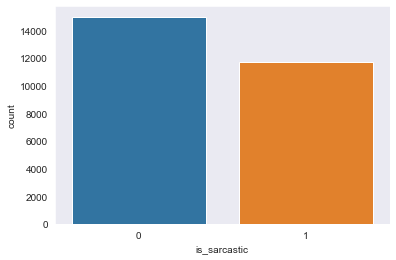

In [40]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [41]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [42]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

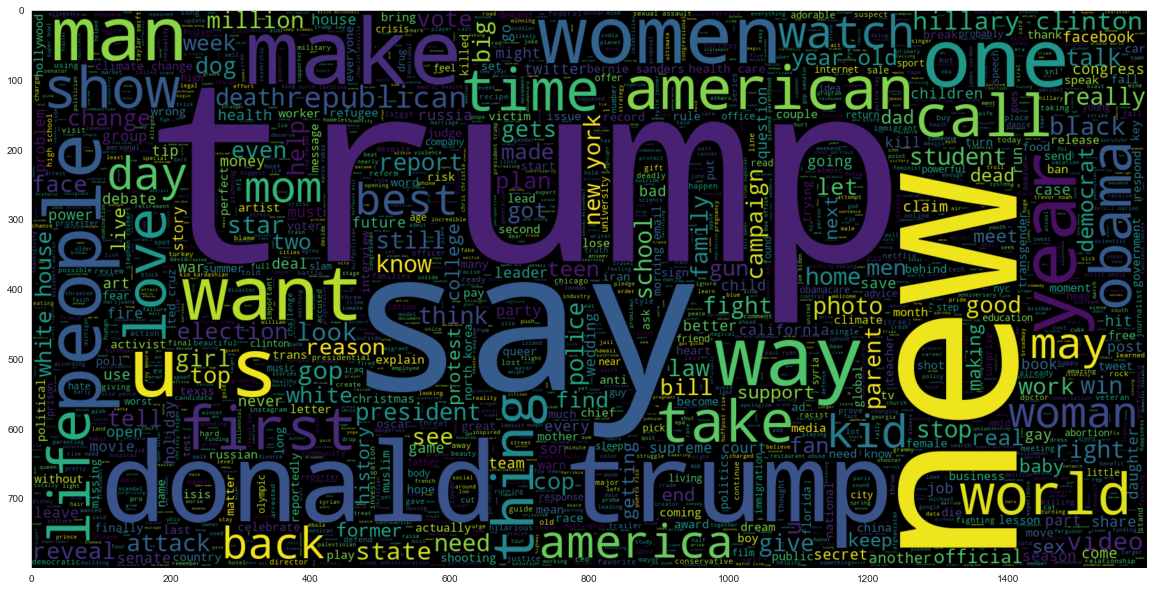

In [43]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

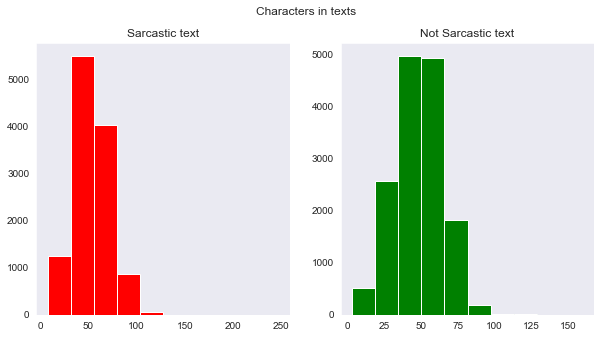

In [44]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

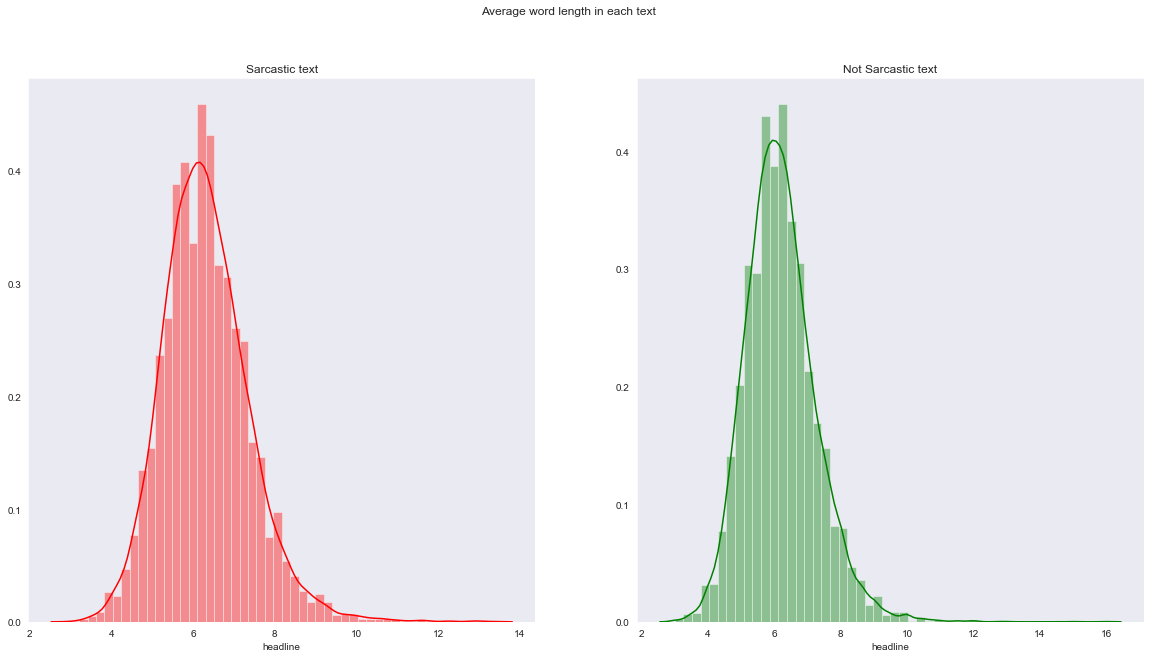

In [45]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [46]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [47]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [48]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

36436

In [49]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [50]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [51]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [52]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [53]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 ,return_sequences = True)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

#model.add(Bidirectional(LSTM(units=64 , return_sequences = True)))
#model.add(LeakyReLU())

model.add(Bidirectional(LSTM(units=32)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

#model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7287400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 20, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                73984     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [56]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 15)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18696 samples, validate on 8013 samples
Epoch 1/15
18696/18696 [==============================] - 35s 2ms/step - loss: 0.5458 - acc: 0.7039 - val_loss: 0.4160 - val_acc: 0.8054
Epoch 2/15
18696/18696 [==============================] - 35s 2ms/step - loss: 0.2295 - acc: 0.9116 - val_loss: 0.4454 - val_acc: 0.8016
Epoch 3/15
18696/18696 [==============================] - 33s 2ms/step - loss: 0.0869 - acc: 0.9718 - val_loss: 0.6967 - val_acc: 0.7928
Epoch 4/15
18696/18696 [==============================] - 32s 2ms/step - loss: 0.0340 - acc: 0.9896 - val_loss: 0.7477 - val_acc: 0.7912
Epoch 5/15
18696/18696 [==============================] - 32s 2ms/step - loss: 0.0168 - acc: 0.9951 - val_loss: 1.0766 - val_acc: 0.7819
Epoch 6/15
18696/18696 [==============================] - 32s 2ms/step - loss: 0.0099 - acc: 0.9976 - val_loss: 1.0099 - val_acc: 0.7863
Epoch 7/15
18696/18696 [==============================] - 32s 2ms/step - loss: 0.0084 - acc: 0.9975 - val_loss: 1.0257 - val_acc:

In [57]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

18696/18696 [==============================] - 6s 336us/step
Accuracy of the model on Training Data is -  99.97860789299011
8013/8013 [==============================] - 3s 343us/step
Accuracy of the model on Testing Data is -  78.02321314811707


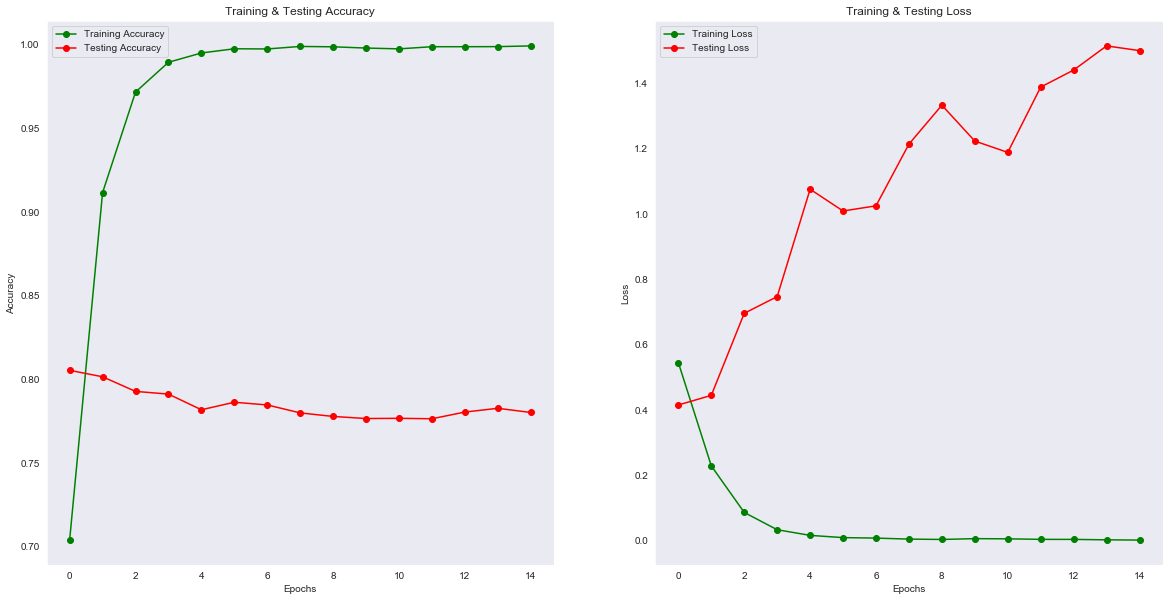

In [58]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [59]:
pred = model.predict_classes(x_test)
pred[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]])

In [61]:
cm = confusion_matrix(y_test,pred)
cm

array([[3674,  809],
       [ 952, 2578]], dtype=int64)

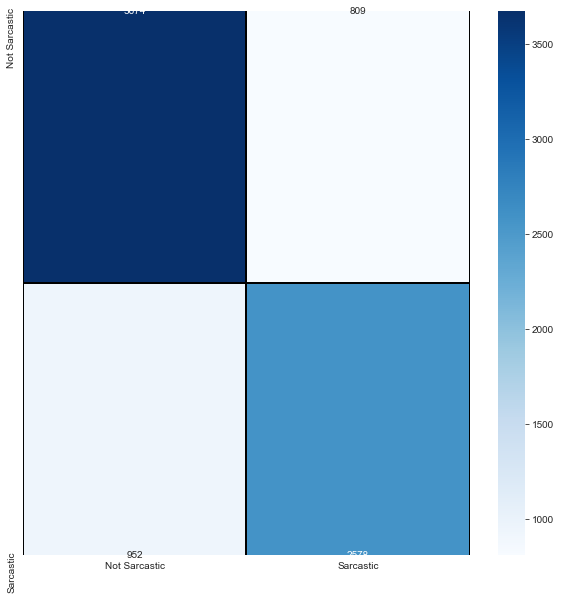

In [62]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])